In [136]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# storing all imports in one place
from scipy.spatial import cKDTree

Your task is to modify `KNNClassifier` class from your practice in class. The `KNNClassifier` class with empty methods is provided below. Please, modify it to do all tasks.

### Task 1 (1 point) <br/>
Create a matrix of object features `X` and vector of labels `y` for N=1000 objects using `sklearn.datasets.make_moons()` function from scikit-learn library. Also, set up random state in the function `random_state=42` and `noise=0.2`. To open the function description use `Shift` + `Tab` .

In [695]:
class KNNClassifier(object):
    
    def __init__(self, max_dist=1., use_kd_tree=False, use_weights=False):
        """
        This is a constructor of the class. 
        Here you can define parameters (max_dist) of the class and 
        attributes, that are visible within all methods of the class.
        
        Parameters
        ----------
        max_dist : float
            Maximum distance between an object and its neighbors.
        """

        # Make this parameter visible in all methods of the class
        self.max_dist = max_dist

        # set flags for different options of prediction methods
        self.use_kd_tree = use_kd_tree
        self.use_weights = use_weights
        
        # creating a cKDTree here as a singleton-object
        self.cKDTree = None 

        # creating field for storing X and Y
        self.X_train = None
        self.y_train = None
                
    
    def fit(self, X, y):
        """
        This method trains the KNN classifier. 
        Actualy, the KNN classifier has no training procedure.
        It just remembers data (X, y) that will be used for predictions.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # Just save X and y. There is no training procedure for KNN classifier
        self.X_train = X
        self.y_train = y
        
    def calculate_distances(self, X, one_x):
        """
        This method calculates distances between one object and all other objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        one_x : numpy.array, shape = (n_features)
        """
        
        dists = np.sqrt( np.sum( (X - one_x)**2, axis=1 ) )

        return dists

    def find_k_neighbours_indices(self, X, one_x):
        """
        This methods returns array of indeces of neighbours of one_x object.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        k_neighbours_indeces - indices of neighbours of one_x object taken from X_train sample.
            Or just one point in case when zero points are inside a circle
            Example:  [
                        [0,1; 0,2],
                        [0,2; 0,3],
                        ...
                      ]
        """
        
        k_neighbours_indices = []
        
        # numpy initial algorithm
        if (not self.use_kd_tree):
            # Calculate distances between an object and all objects from train smaple
            distances = self.calculate_distances(self.X_train, one_x)
            # distances = [0.25, 0.10, 0.32, 0.05] (example)

            # extract indeces which are inside circle
            k_neighbours_indices = np.where(distances < self.max_dist)

            if (len(k_neighbours_indices) < 1):
                k_neighbours_indices = np.argmin(distances, axis = 1)
        
        # cKDTree
        else:
            # implementing something like a singleton pattern
            if (self.cKDTree == None):
                self.cKDTree = cKDTree(X, leafsize = 30)
                
            k_neighbours_indices = self.cKDTree.query_ball_point(one_x, self.max_dist)
            
        return k_neighbours_indices
    
    
    def predict_proba(self, X):
        """
        This methods performs prediction of probabilities of each class for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        y_predicted_proba : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class. 
            Example:
                y_predicted_proba = [[0.1, 0.9],
                                     [0.8, 0.2], 
                                     [0.0, 1.0], 
                                     ...]
        """
        
        # Create an empty list for predictions
        y_predicted_proba = []
        
        ### Replace these lines with your code:
         # For each object in X make prediction
        for one_x in X:
            # finding indeces of neighbours
            k_neighbours_indeces = self.find_k_neighbours_indices(X_train, one_x)

            # Get labels of these k_neighbors
            k_neighbours_labels = self.y_train[k_neighbours_indeces]
            # k_neighbors_labels = [0, 1, 0] (example)
                      
            unique_labels = np.unique(self.y_train)
            print(unique_labels)
            weights_for_label = []
            
            for group in unique_labels:
                # getting only those elements who are of this group
                indeces_of_neighbours = np.where(k_neighbours_labels == group)[0]
                
                # mapping indexes (i am new to python and i dont know how to do this elegant)
                # -----------------
                # i tried X_points = X[k_neighbours_indeces[indeces_of_neighbours]] 
                # but this didnt work out of box
                index_mapping_arr = []
                for index in indeces_of_neighbours:
                    index_mapping_arr.append(k_neighbours_indeces[index])
                X_points = X[index_mapping_arr]
                
                # saving weight for group
                distances_within_group = self.calculate_distances(X_points, one_x)
                sum_of_distances = np.sum(1 / distances_within_group)
                weights_for_label.append(sum_of_distances)

            # TODO доделать гавно
            sum_of_weights = np.sum(weights_for_label)
            ind_of_inf = np.where(np.isinf(weights_for_label))
            print('found infinity at', ind_of_inf)
            if (len(ind_of_inf) == 1):
                for i in np.where(np.isinf(weights_for_label) == False):
                    weights_for_label[i] = 0.0
                weights_for_label[ind_of_inf] = 1.0
                
            print(weights_for_label)
            
            # Save the predicted label
            y_predicted_proba.append(weights_for_label / sum_of_weights)
        ### The end of your code
            
        return np.array(y_predicted_proba) # return numpy.array

    def find_label_max_count(self, X, k_neighbours_indeces, k_neighbours_labels, one_x):      
        # initial numpy algorithm
        if (not self.use_weights):
            # Get list of unique labels and counts of each label
            unique_labels, label_counts = np.unique(k_neighbours_labels, return_counts=True)
            # unique_labels = [0, 1] (example)
            # label_counts  = [2, 1] (example)

            # Get label with the maximum count
            label_max_count = unique_labels[label_counts == label_counts.max()][0]
            # label_max_count = 0 (example)
            
            return label_max_count
        
        # weighted voting
        else:
            unique_labels = np.unique(k_neighbours_labels)
            
            # if only 1 point is recognized as neighbour
            if (len(unique_labels) < 2):
                return unique_labels[0]
            
            weights_for_label = []
            
            for group in unique_labels:
                # getting only those elements who are of this group
                indeces_of_neighbours = np.where(k_neighbours_labels == group)[0]
                
                # mapping indexes (i am new to python and i dont know how to do this elegant)
                # -----------------
                # i tried X_points = X[k_neighbours_indeces[indeces_of_neighbours]] 
                # but this didnt work out of box
                index_mapping_arr = []
                for index in indeces_of_neighbours:
                    index_mapping_arr.append(k_neighbours_indeces[index])
                X_points = X[index_mapping_arr]
                
                # saving weight for group
                distances_within_group = self.calculate_distances(X_points, one_x)
                sum_of_distances = np.sum(1 / distances_within_group)
                weights_for_label.append(sum_of_distances)

            return np.argmax(weights_for_label)
    
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        y_predicted : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """

       # Create an empty list for predicted labels
        y_predicted = []
        
        # For each object in X make prediction
        for one_x in X:
            # one_x = [0.2, 0.57] (example)
            
            # finding indeces of neighbours
            k_neighbours_indeces = self.find_k_neighbours_indices(X_train, one_x)

            # Get labels of these k_neighbors
            k_neighbours_labels = self.y_train[k_neighbours_indeces]
            # k_neighbors_labels = [0, 1, 0] (example)
                      
            label_max_count = self.find_label_max_count(X_train, k_neighbours_indeces, k_neighbours_labels, one_x)
            
            # Save the predicted label
            y_predicted.append(label_max_count)
            
        return np.array(y_predicted) # return numpy.array

In [696]:
### Your code here
from sklearn.datasets import make_moons, load_iris # import function from the library

N = 1000

X, y = make_moons(n_samples=N, noise=0.2, random_state=42) # generate data sample


### Check your solution
ans = np.array([[-0.112,  0.52 ],
                [ 1.143, -0.343]])
assert np.array_equal(np.round(X[:2], 3), ans), ('Check your solution.')

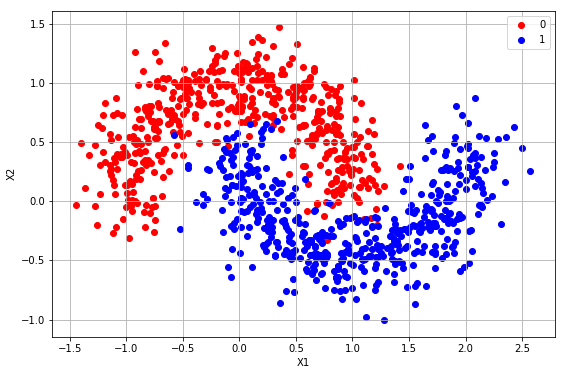

In [697]:
# Create an figure with a custom size
plt.figure(figsize=(9, 6))

# Plot all objects with y == 0 (class 0)
plt.scatter(X[y == 0, 0],     # selects all objects with y == 0 and the 1st column of X
            X[y == 0, 1],     # selects all objects with y == 0 and the 2nd column of X
            color='r',        # points color
            label='0')        # label for the plot legend


# Plot all objects with y == 1 (class 1)
plt.scatter(X[y == 1, 0],     # selects all objects with y == 1 and the 1st column of X
            X[y == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
            color='b',        # points color
            label='1')        # label for the plot legend

plt.xlabel('X1') # set up X-axis label
plt.ylabel('X2') # set up Y-axis label

plt.legend(loc='best') # create the plot legend and set up it position
plt.grid(b=1) # create grid on the plot

plt.show() # display the plot

### Task 2 (1 point) <br/>

Split the sample into train and test samples using `sklearn.model_selection.train_test_split()` function from scikit-learn library. Use `random_state = 42` and `test_size = 0.5`.

In [698]:
### Your code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    # 50% for test, 50% for train
                                                    random_state=42) # shuffle objects before split


### Check your solution
ans = np.array([[ 0.77 , -0.289],
                [ 0.239,  1.041]])
assert np.array_equal(np.round(X_train[:2], 3), ans), ('Check your solution.')

### Task 3 (2 points) <br/>

Modify class `KNNClassifier` above and implement `predict()` method that uses **max_dist** parameter to select neighbors like it's shown in the second figure (radius search). If there is no any object within **max_dist**, make decision based on the closest neighbor.

<img src="https://github.com/hushchyn-mikhail/hse_se_ml/blob/S02/2020/s02-metric-based-methods%20/img/knn2.png?raw=1" width="600">

In [699]:
# Create a class object
knn = KNNClassifier(max_dist=0.5)

# Train the classifier
knn.fit(X_train, y_train)

# Make prediction using the trained classifier
%time y_test_predict = knn.predict(X_test) # measure time for prediction

# Import accuracy_score function
from sklearn.metrics import accuracy_score
# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)
print("Test accuracy of KNN classifier: ", accuracy_test)


### Check your solution
assert accuracy_test == 0.964, ('Check your solution.')

Wall time: 21.9 ms
Test accuracy of KNN classifier:  0.964


### Task 4 (2 points) <br/>

There are an algorithm [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) that helps to find neighbors faster. Using [scipy.spatial.cKDTree](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.cKDTree.html#scipy.spatial.cKDTree) function modify you classifier to speed up **predict** method. Use `leafsize=30` in `KDTree`. Similar to `max_dist` option, add option `use_kd_tree = True/False` to your classifier.

In [700]:
# Create a class object
knn = KNNClassifier(max_dist=0.5, use_kd_tree=True)

# Train the classifier
knn.fit(X_train, y_train)

# Make prediction using the trained classifier
%time y_test_predict = knn.predict(X_test) # measure time for prediction

# Import accuracy_score function
from sklearn.metrics import accuracy_score
# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)
print("Test accuracy of KNN classifier: ", accuracy_test)

### Check your solution
assert accuracy_test == 0.964, ('Check your solution.')

Wall time: 19 ms
Test accuracy of KNN classifier:  0.964


### Task 5 (3 points) <br/>

Now modify the **predict** method to provide prediction with neighbors weights.

<img src="https://github.com/hushchyn-mikhail/hse_se_ml/blob/S02/2020/s02-metric-based-methods%20/img/wv1.png?raw=1">

<img src="https://github.com/hushchyn-mikhail/hse_se_ml/blob/S02/2020/s02-metric-based-methods%20/img/wv2.png?raw=1">

We propose you to use the following weights:

$$
w_{i} = \frac{1}{\rho(x, x_{i})}
$$

Similar to `max_dist` option, add option `use_weights = True/False` to your classifier.

In [701]:
# Create a class object
knn = KNNClassifier(max_dist=0.5, use_kd_tree=True, use_weights=True)

# Train the classifier
knn.fit(X_train, y_train)

# Make prediction using the trained classifier
%time y_test_predict = knn.predict(X_test) # measure time for prediction

# Import accuracy_score function
from sklearn.metrics import accuracy_score
# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)
print("Test accuracy of KNN classifier: ", accuracy_test)

### Check your solution
assert accuracy_test == 0.968, ('Check your solution.')

Wall time: 36.3 ms
Test accuracy of KNN classifier:  0.968


### Task 6 (3 points) <br/>

Develop **predict_proba** method of the classifier. For each object this method returns probability that the object belongs to each of the classes. 

For each object $x$ probability for each class is defined as:

$$
p_{c}(x) = \frac{g_{c}(x)}{\sum_{i=1}^{C} g_{i}(x)}
$$

where $C$ is number of classes.

Then, the object has a vector of probabilities:

$$
p(x) = (p_{1}(x), p_{2}(x), ..., p_{C}(x))
$$

Use neighbors weights as in Task 5.

In [702]:
# Create a class object
knn = KNNClassifier(max_dist=0.5, use_kd_tree=True, use_weights=True)

# Train the classifier
knn.fit(X_train, y_train)

# Make prediction using the trained classifier
%time y_test_predict_proba = knn.predict_proba(X_test) # measure time for prediction

# Example of the output
y_test_predict_proba[:10, :] # the first 10 rows



### Check your solution
ans = np.array([[0.046, 0.954],
                [0.962, 0.038]])
assert np.array_equal(np.round(y_test_predict_proba[:2], 3), ans), ('Check your solution.')

[0 1]
found infinity at (array([1], dtype=int64),)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in true_divide


TypeError: only integer scalar arrays can be converted to a scalar index

AssertionError: Check your solution.